# 12-770 Spring 2025: Retro Radiators Modeling

Barbara Castro-Schell, Adwoa Asare, and Ziyuan Ma
2025-04-22

We will follow a very similar procedure as was done for Homework #2. Use Jupyter Notebooks to edit the file.

## Import data from sensors and PurpleAir data for radiator off

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Read the CSV files
df_sensor = pd.read_csv('rad_off_data.csv', index_col=0, parse_dates=True)
df_outdoor = pd.read_csv('outdoor_temps.csv', index_col=0, parse_dates=True)

# Ensure the index is datetime for both DataFrames and set timezone awareness
df_sensor.index = pd.to_datetime(df_sensor.index, errors='coerce').tz_localize(None)
df_outdoor.index = pd.to_datetime(df_outdoor.index, errors='coerce').tz_localize(None)

# Drop the 'temperature (outdoor)' column from df_sensor
df_sensor.drop(columns=['temperature (outdoor)'], inplace=True)

# Combine df_sensor and df_outdoor based on timestamp difference
df_sensor['outdoor_temp'] = np.nan  # Initialize the outdoor_temp column
df_sensor['duty_cycle'] = 0  # Initialize the duty_cycle column
df_sensor['dt'] = np.nan

# Iterate through df_sensor and find matching timestamps in df_outdoor
for sensor_idx, sensor_row in df_sensor.iterrows():
    # Find rows in df_outdoor where the timestamp difference is less than 5 minutes
    matching_outdoor = df_outdoor.loc[abs(df_outdoor.index - sensor_idx) < pd.Timedelta(minutes=5)]
    if not matching_outdoor.empty:
        # Take the first matching value (if multiple matches exist)
        df_sensor.at[sensor_idx, 'outdoor_temp'] = matching_outdoor.iloc[0]['temp C']

# Match temp_rad and humidity_rad 

# Display the updated df_sensor
df_sensor.head(25)

,sensor_id,humidity_rad,temp_rad,humidity_room,temp_room,outdoor_temp,duty_cycle,dt
timestamp,,,,,,,,
2025-04-02 20:02:00,radiator,41.3,25.5,NaN,NaN,15.443889,0,NaN
2025-04-02 20:04:00,room,NaN,NaN,40.5,23.3,15.443889,0,NaN
2025-04-02 20:11:00,radiator,41.0,24.9,NaN,NaN,15.666667,0,NaN
2025-04-02 20:14:00,room,NaN,NaN,41.5,23.3,15.666667,0,NaN
2025-04-02 20:21:00,radiator,51.4,20.1,NaN,NaN,16.332778,0,NaN
2025-04-02 20:24:00,room,NaN,NaN,41.8,23.0,16.332778,0,NaN
2025-04-02 20:31:00,radiator,51.2,20.0,NaN,NaN,16.555000,0,NaN
2025-04-02 20:34:00,room,NaN,NaN,41.5,22.8,16.555000,0,NaN
2025-04-02 20:41:00,radiator,51.1,19.9,NaN,NaN,16.777778,0,NaN


# Define ti function that calculates the next step Ti using a thermodynamic model

In [2]:
# We can implement this function as Python code to calculate the next step Ti
def ti(inputs, R, C, P):

    ta = inputs[:,0]  # ambient temp

    mu = inputs[:,1]  # duty cycle
    dt = inputs[:,2]   # timestep
    y = np.zeros(len(inputs))
    y[0] = inputs[0,0] # use first value from data

    for t in range(1,len(y)):
        y[t] = 1/(C/dt[t]+1/R) * (C/dt[t]*y[t-1] + 1/R*ta[t] + mu[t]*P)
    return y

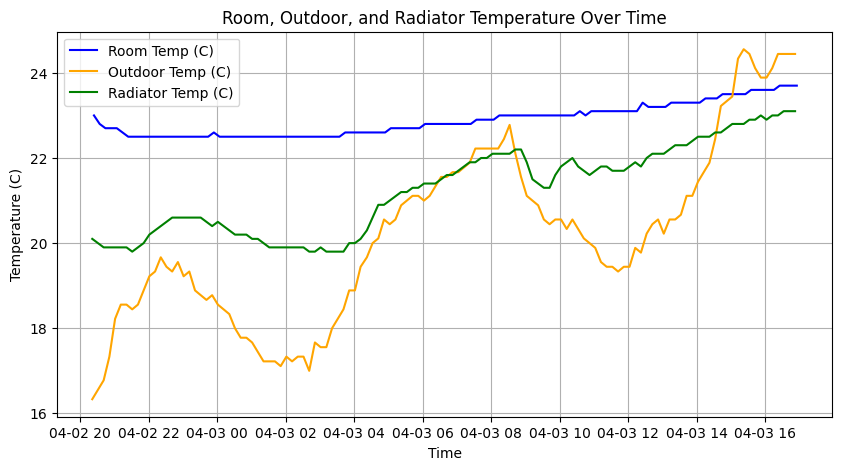

In [3]:
selectedCols1 = ['outdoor_temp', 'duty_cycle', 'dt', 'temp_room']  # Select the relevant columns
selectedCols2 = ['outdoor_temp', 'duty_cycle', 'dt', 'temp_rad']  # Select the radiator temperature column
indoorTemp = 'temp_room'
radTemp = 'temp_rad'

# Drop NaN values from the radiator temperature column
df2 = df_sensor[selectedCols2].dropna(subset=[radTemp])
df2['dt'] = df2.index.to_series().diff().dt.total_seconds()  # Calculate the time difference in seconds

# Ensure df2 index is unique and sorted
df2 = df2[~df2.index.duplicated(keep='first')].sort_index()
df2 = df2.drop(df2.index[0:2])  # Drop the first row to avoid NaN in the first time difference
# print(df2.head(5))
# print(df2.tail(15))

# Drop rows with NaN values in the indoor temperature column
df1 = df_sensor[selectedCols1].dropna(subset=[indoorTemp])
df1['dt'] = df1.index.to_series().diff().dt.total_seconds()  # Calculate the time difference in seconds
df1 = df1.drop(df1.index[0:2])  # Drop the first row to avoid NaN in the first time difference

# Drop values in df2 that come after the end of df1 data
df2 = df2[df2.index <= df1.index.max()]

df1['outdoor_temp'] = df2['outdoor_temp'].reindex(df1.index, method='ffill')  # Forward fill outdoor temperature to match df1 index
# print(df1.tail(15))

# Plot the time vs room temp, outdoor temp, and radiator temp
plt.figure(figsize=(10, 5))
plt.plot(df1.index, df1[indoorTemp], label='Room Temp (C)', color='blue')
# plt.plot(df1.index, df1['outdoor_temp'], label='Outdoor Temp (C)', color='orange')
plt.plot(df2.index, df2['outdoor_temp'], label='Outdoor Temp (C)', color='orange')
plt.plot(df2.index, df2[radTemp], label='Radiator Temp (C)', color='green')

plt.xlabel('Time')
plt.ylabel('Temperature (C)')
plt.title('Room, Outdoor, and Radiator Temperature Over Time')
plt.legend()
plt.grid()
plt.show()

### Estimate RC values using this data

$$\Big(\frac{C}{\mathrm{d}t}+\frac{1}{R}\Big)T_i^{t+1} = \frac{C}{\mathrm{d}t}T_i^{t}+\frac{1}{R}T_a^{t+1}+\mu^{t+1}COP*P$$

In [4]:


def loss(df1, R, C):
    return np.sum((df1[indoorTemp].values - ti(df1.to_numpy(), R, C, 0, 0))**2)

# Initial estimates for R and C
# initial_estimates = [0.1, 500000]
initial_estimates = [0.1, 500000]

# Use curve_fit to estimate R and C
params1, covariance1 = curve_fit(
    lambda inputs, R, C: ti(inputs, R, C, 0),
    df1.to_numpy(),
    df1[indoorTemp].values,
    p0=initial_estimates,
)

params2, covariance2 = curve_fit(
    lambda inputs, R, C: ti(inputs, R, C, 0),
    df2.to_numpy(),
    df2[radTemp].values,
    p0=initial_estimates,
)

R_estimated1, C_estimated1 = params1
R_estimated2, C_estimated2 = params2

# Calculate the thermal time constant
tau_seconds1 = R_estimated1 * C_estimated1
tau_hours1 = tau_seconds1 / 3600

tau_seconds2 = R_estimated2 * C_estimated2
tau_hours2 = tau_seconds2 / 3600

KequalsInF = 1.8  # C to F conversion factor

# Print results
print("Using temperature data from the room sensor attached to the wall:")
print(f"\nEstimated R: {R_estimated1*KequalsInF:.6} °F/W or {R_estimated1:.6} °C/W")
print(f"Estimated C: {C_estimated1 / KequalsInF:.10} J/°F or {C_estimated1:.9} J/°C")
print(f"Thermal Time Constant: {tau_seconds1:.7} seconds or {tau_hours1:.4} hours")

# Print results
print("\nUsing temperature data from the radiator sensor while radiator was off:")
print(f"Estimated R: {R_estimated1*KequalsInF:.6} °F/W or {R_estimated1:.6} °C/W")
print(f"Estimated C: {C_estimated1 / KequalsInF:.10} J/°F or {C_estimated1:.9} J/°C")
print(f"Thermal Time Constant: {tau_seconds2:.7} seconds or {tau_hours2:.4} hours")

Using temperature data from the room sensor attached to the wall:

Estimated R: -0.0236538 °F/W or -0.013141 °C/W
Estimated C: 9137.578555 J/°F or 16447.6414 J/°C
Thermal Time Constant: -216.1385 seconds or -0.06004 hours

Using temperature data from the radiator sensor while radiator was off:
Estimated R: -0.0236538 °F/W or -0.013141 °C/W
Estimated C: 9137.578555 J/°F or 16447.6414 J/°C
Thermal Time Constant: -98.58687 seconds or -0.02739 hours


# Import data for radiator on and process it to create usable dataframe

In [5]:
# Read the CSV files
df_testing = pd.read_csv('all_data_408to411.csv', index_col=0, parse_dates=True)

# Create a dataframe with 'insulation_on' and 'rad_status' columns
df_radinfo = pd.DataFrame(df_testing, columns=['insulation_on', 'rad_status'])

df_testing.head()
df_testing.columns = ['sensor_id', 'temperature', 'humidity','outdoor_temp', 'rad_status', 'insulation_on']

# Ensure the index is datetime for both DataFrames and set timezone awareness
df_testing.index = pd.to_datetime(df_testing.index, errors='coerce').tz_localize(None)

df_testing = df_testing.pivot_table(
    index='timestamp',            # What you want to be your rows
    columns=['sensor_id'],  # These will become multi-indexed columns
    values= ['temperature', 'humidity', 'outdoor_temp', 'rad_status', 'insulation_on']           # Values to fill the table
)

df_testing.columns = ['humidity_rad', 'humidity_room', 'insulation_on_rad', 'insulation_on_room', 'rad_status_rad','rad_status_room', 'temp_rad', 'temp_room']
df_testing.head(20)

# Drop insulation_on_rad and rad_status_rad columns
df_testing.drop(columns=['insulation_on_rad', 'rad_status_rad'], inplace=True)

# Rename column "rad_status_room" to "rad_status" and "insulation_on_room" to "insulation_on"
df_testing.rename(columns={'rad_status_room': 'rad_status'}, inplace=True)
df_testing.rename(columns={'insulation_on_room': 'insulation_on'}, inplace=True)

# Assign all the values for rad_status and insulation_on to 0
df_testing['rad_status'] = 0  
df_testing['insulation_on'] = 0

# Iterate through df_sensor and find matching timestamps in df_radinfo
for sensor_idx, sensor_row in df_testing.iterrows():
    # Find rows in df_outdoor where the timestamp difference is less than 5 minutes
    matching = df_radinfo.loc[abs(df_radinfo.index - sensor_idx) < pd.Timedelta(minutes=5)]
    if not matching.empty:
        # Take the first matching value (if multiple matches exist)
        df_testing.at[sensor_idx, 'rad_status'] = matching.iloc[0]['rad_status']
        df_testing.at[sensor_idx, 'insulation_on'] = matching.iloc[0]['insulation_on']

# Add an outdoor_temp column to the df_testing dataframe
df_testing['outdoor_temp'] = np.nan  # Initialize the outdoor_temp column
df_testing['duty_cycle'] = 0  # Initialize the duty_cycle column
df_testing['dt'] = np.nan


# Iterate through df_testing and find matching timestamps in df_outdoor
for sensor_idx, sensor_row in df_testing.iterrows():
    # Find rows in df_outdoor where the timestamp difference is less than 5 minutes
    matching_outdoor = df_outdoor.loc[abs(df_outdoor.index - sensor_idx) < pd.Timedelta(minutes=5)]
    if not matching_outdoor.empty:
        # Take the first matching value (if multiple matches exist)
        df_testing.at[sensor_idx, 'outdoor_temp'] = matching_outdoor.iloc[0]['temp C']

df_testing.head(10)


C:\Users\robot\AppData\Local\Temp\ipykernel_63176\1329722562.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_testing.at[sensor_idx, 'rad_status'] = matching.iloc[0]['rad_status']


,humidity_rad,humidity_room,insulation_on,rad_status,temp_rad,temp_room,outdoor_temp,duty_cycle,dt
timestamp,,,,,,,,,
2025-04-08 14:00:00,NaN,21.8,0,0.5,NaN,27.2,8.888889,0,NaN
2025-04-08 18:08:00,NaN,22.3,0,0.5,NaN,18.8,8.333333,0,NaN
2025-04-08 18:09:00,NaN,22.1,0,0.5,NaN,19.0,8.333333,0,NaN
2025-04-08 18:11:00,16.7,NaN,0,0.5,28.9,NaN,8.333333,0,NaN
2025-04-08 18:13:00,17.0,NaN,0,0.5,28.1,NaN,8.333333,0,NaN
2025-04-08 18:14:00,NaN,22.4,0,0.5,NaN,18.6,8.333333,0,NaN
2025-04-08 19:13:00,16.0,NaN,0,0.5,28.4,NaN,8.555000,0,NaN
2025-04-08 19:14:00,NaN,22.3,0,0.5,NaN,18.4,8.555000,0,NaN
2025-04-08 19:23:00,15.9,NaN,0,0.5,28.5,NaN,8.666667,0,NaN


### Separating rad temp and room temp for analysis and compatibility in ti function

In [6]:
selectedCols1 = ['outdoor_temp', 'rad_status', 'dt', 'temp_room', 'duty_cycle', 'insulation_on']  # Select the relevant columns
selectedCols2 = ['outdoor_temp', 'rad_status', 'dt', 'temp_rad', 'duty_cycle', 'insulation_on']  # Select the radiator temperature column
indoorTemp = 'temp_room'
radTemp = 'temp_rad'

# Drop NaN values from the radiator temperature column
df3 = df_testing[selectedCols2].dropna(subset=[radTemp])
df3['outdoor_temp'] = df3['outdoor_temp'].interpolate(method='linear')
df3['dt'] = df3.index.to_series().diff().dt.total_seconds()  # Calculate the time difference in seconds

# Ensure df2 index is unique and sorted
df3 = df3[~df3.index.duplicated(keep='first')].sort_index()
df3 = df3.drop(df3.index[0])  # Drop the first row to avoid NaN in the first time difference

# Drop rows with NaN values in the indoor temperature column
df4 = df_testing[selectedCols1].dropna(subset=[indoorTemp])
df4['outdoor_temp'] = df4['outdoor_temp'].interpolate(method='linear')  #Interpolate missing outdoor temp values
df4['dt'] = df4.index.to_series().diff().dt.total_seconds()  # Calculate the time difference in seconds
df4 = df4.drop(df4.index[0])  # Drop the first row to avoid NaN in the first time difference

df3['outdoor_temp'] = df4['outdoor_temp'].reindex(df3.index, method='ffill')  # Forward fill outdoor temperature to match df1 index


In [7]:

# print(df3.head(10))
# print(df3.tail(10))

# print(df4.head(10))
# print(df4.tail(10))

### Plot room, radiator, and outdoor temperature for 04-08 18:13 to 04-11 17:31

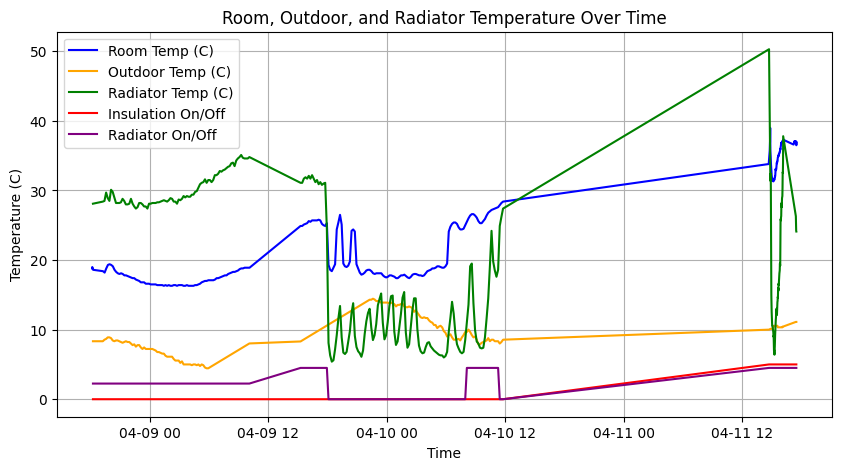

In [8]:

# Plot the time vs room temp, outdoor temp, and radiator temp
plt.figure(figsize=(10, 5))
plt.plot(df4.index, df4[indoorTemp], label='Room Temp (C)', color='blue')
# plt.plot(df1.index, df1['outdoor_temp'], label='Outdoor Temp (C)', color='orange')
plt.plot(df3.index, df3['outdoor_temp'], label='Outdoor Temp (C)', color='orange')
plt.plot(df3.index, df3[radTemp], label='Radiator Temp (C)', color='green')
plt.plot(df3.index, df3['insulation_on']*5, label='Insulation On/Off', color='red')
plt.plot(df3.index, df3['rad_status']*4.5, label='Radiator On/Off', color='purple')

plt.xlabel('Time')
plt.ylabel('Temperature (C)')
plt.title('Room, Outdoor, and Radiator Temperature Over Time')
plt.legend()
plt.grid()
plt.show()



#### Looks like the radiators are turned down at night. Also, there is a data gap between 04-10 12 and 04-11 14. Let's change the rad_status variable to 0 for the hours between 18:00 and 8:00. 

### Use the data from the graph above and the corresponding radiator status (mu) and the a guess for the power P to calculate the RC values

In [9]:
# Initial estimates for R and C
initial_estimates = [0.1, 500000]

# Guesses for COP and P
P = 1000  # Power of the radiator in Watts

# Create dataframes for insulation on and off
df3_insoff = df3[df3['insulation_on'] == 0]  # Insulation off
df3_inson = df3[df3['insulation_on'] == 1]  # Insulation on
df3_inson = df3_inson.drop(df3_inson.index[0])
df4_insoff = df4[df4['insulation_on'] == 0]  # Insulation off
df4_insoff = df4_insoff.drop(df4_insoff.index[0])
df4_inson = df4[df4['insulation_on'] == 1] # Insulation on and drop first row
df4_inson = df4_inson.drop(df4_inson.index[0])

# print(df3_insoff.head(10))
# print(df3_inson.head(10))
# print(df4_insoff.head(30))
# print(df4_insoff.tail(30))
# print(df4_inson.head(30))
# print(df4_inson.tail(30))

# Use curve_fit to estimate R and C when inslation is off
params3_insoff, covariance3_insoff = curve_fit(
    lambda inputs, R, C: ti(inputs, R, C, P),
    df3_insoff.to_numpy(),
    df3_insoff[radTemp].values,
    p0=initial_estimates,
)

# Use curve_fit to estimate R and C when inslation is on
params3_inson, covariance3_inson = curve_fit(
    lambda inputs, R, C: ti(inputs, R, C, P),
    df3_inson.to_numpy(),
    df3_inson[radTemp].values,
    p0=initial_estimates,
)

params4_insoff, covariance4_insoff = curve_fit(
    lambda inputs, R, C: ti(inputs, R, C, P),
    df4_insoff.to_numpy(),
    df4_insoff[indoorTemp].values,
    p0=initial_estimates,
)

params4_inson, covariance4_inson = curve_fit(
    lambda inputs, R, C: ti(inputs, R, C, P),
    df4_inson.to_numpy(),
    df4_inson[indoorTemp].values,
    p0=initial_estimates,
)

R_estimated3_insoff, C_estimated3_insoff = params3_insoff
R_estimated3_inson, C_estimated3_inson = params3_inson
R_estimated4_insoff, C_estimated4_insoff = params4_insoff
R_estimated4_inson, C_estimated4_inson = params4_inson

# Calculate the thermal time constant
tau_seconds3_insoff = R_estimated3_insoff * C_estimated3_insoff
tau_hours3_insoff = tau_seconds3_insoff / 3600

tau_seconds4_insoff = R_estimated4_insoff * C_estimated4_insoff
tau_hours4_insoff = tau_seconds4_insoff / 3600

tau_seconds3_inson = R_estimated3_inson * C_estimated3_inson
tau_hours3_inson = tau_seconds3_inson / 3600

tau_seconds4_inson = R_estimated4_inson * C_estimated4_inson
tau_hours4_inson = tau_seconds4_inson / 3600

KequalsInF = 1.8  # C to F conversion factor

# Print results
print(f"Using the radiator temperature data, insulation off, and assuming the power of the radiator to be {P} W:")
print(f"Estimated R: {R_estimated3_insoff*KequalsInF:.6} °F/W or {R_estimated3_insoff:.6} °C/W")
print(f"Estimated C: {C_estimated3_insoff / KequalsInF:.10} J/°F or {C_estimated3_insoff:.9} J/°C")
print(f"Thermal Time Constant: {tau_seconds3_insoff:.7} seconds or {tau_hours3_insoff:.4} hours")

# Print results
print(f"\nUsing the room temperature, insulation off, measured at the wall data and assuming the power of the radiator to be {P} W:")
print(f"Estimated R: {R_estimated4_insoff*KequalsInF:.6} °F/W or {R_estimated4_insoff:.6} °C/W")
print(f"Estimated C: {C_estimated4_insoff / KequalsInF:.10} J/°F or {C_estimated4_insoff:.9} J/°C")
print(f"Thermal Time Constant: {tau_seconds4_insoff:.7} seconds or {tau_hours4_insoff:.4} hours")

# Print results
print(f"\nUsing the radiator temperature data, insulation on, and assuming the power of the radiator to be {P} W:")
print(f"Estimated R: {R_estimated3_inson*KequalsInF:.6} °F/W or {R_estimated3_inson:.6} °C/W")
print(f"Estimated C: {C_estimated3_inson / KequalsInF:.10} J/°F or {C_estimated3_inson:.9} J/°C")
print(f"Thermal Time Constant: {tau_seconds3_inson:.7} seconds or {tau_hours3_inson:.4} hours")

# Print results
print(f"\nUsing the room temperature, insulation on, measured at the wall data and assuming the power of the radiator to be {P} W:")
print(f"Estimated R: {R_estimated4_inson*KequalsInF:.6} °F/W or {R_estimated4_inson:.6} °C/W")
print(f"Estimated C: {C_estimated4_inson / KequalsInF:.10} J/°F or {C_estimated4_inson:.9} J/°C")
print(f"Thermal Time Constant: {tau_seconds4_inson:.7} seconds or {tau_hours4_inson:.4} hours")

# Print ratio between tau for insulation on vs insulation off
print(f"\nThe ratio for the thermal time constant for insulation on/insulation off is {tau_seconds3_insoff/tau_seconds3_inson} for radiator temperatures and") 
print(f"{tau_seconds4_insoff/tau_seconds4_inson} for room temperatures.")

Using the radiator temperature data, insulation off, and assuming the power of the radiator to be 1000 W:
Estimated R: 0.0516271 °F/W or 0.0286817 °C/W
Estimated C: 87100.44067 J/°F or 156780.793 J/°C
Thermal Time Constant: 4496.742 seconds or 1.249 hours

Using the room temperature, insulation off, measured at the wall data and assuming the power of the radiator to be 1000 W:
Estimated R: 0.0632388 °F/W or 0.0351326 °C/W
Estimated C: 1054911.988 J/°F or 1898841.58 J/°C
Thermal Time Constant: 66711.32 seconds or 18.53 hours

Using the radiator temperature data, insulation on, and assuming the power of the radiator to be 1000 W:
Estimated R: 0.0807117 °F/W or 0.0448399 °C/W
Estimated C: 169984.1686 J/°F or 305971.503 J/°C
Thermal Time Constant: 13719.72 seconds or 3.811 hours

Using the room temperature, insulation on, measured at the wall data and assuming the power of the radiator to be 1000 W:
Estimated R: 0.0436351 °F/W or 0.0242417 °C/W
Estimated C: -156.7664204 J/°F or -282.179557

#### Data from this set for insulation on is very limited. Let's also look at the data for 04-15 through 04-17.

In [10]:
# Read the CSV files
df_testing1 = pd.read_csv('all_data_415to417.csv', index_col=0, parse_dates=True)
df_outdoor1 = pd.read_csv('outdoor_temps2.csv', index_col=0, parse_dates=True)

df_testing1.index = pd.to_datetime(df_testing1.index, errors='coerce').tz_localize(None)
df_outdoor1.index = pd.to_datetime(df_outdoor1.index, errors='coerce').tz_localize(None)

# Create a dataframe with 'insulation_on' and 'rad_status' columns
df_radinfo1 = pd.DataFrame(df_testing1, columns=['insulation_on', 'rad_status'])

df_testing1.head()
df_testing1.columns = ['sensor_id', 'temperature', 'humidity','outdoor_temp', 'rad_status', 'insulation_on']

# Ensure the index is datetime for both DataFrames and set timezone awareness
df_testing1.index = pd.to_datetime(df_testing1.index, errors='coerce').tz_localize(None)

df_testing1 = df_testing1.pivot_table(
    index='timestamp',            # What you want to be your rows
    columns=['sensor_id'],  # These will become multi-indexed columns
    values= ['temperature', 'humidity', 'outdoor_temp', 'rad_status', 'insulation_on']           # Values to fill the table
)

df_testing1.columns = ['humidity_rad', 'humidity_room', 'insulation_on_rad', 'insulation_on_room', 'rad_status_rad','rad_status_room', 'temp_rad', 'temp_room']
# df_testing1.head(20)

# Drop insulation_on_rad and rad_status_rad columns
df_testing1.drop(columns=['insulation_on_rad', 'rad_status_rad'], inplace=True)

# Rename column "rad_status_room" to "rad_status" and "insulation_on_room" to "insulation_on"
df_testing1.rename(columns={'rad_status_room': 'rad_status'}, inplace=True)
df_testing1.rename(columns={'insulation_on_room': 'insulation_on'}, inplace=True)

# Assign all the values for rad_status and insulation_on to 0
df_testing1['rad_status'] = 0  
df_testing1['insulation_on'] = 0

# Iterate through df_sensor and find matching timestamps in df_radinfo
for sensor_idx, sensor_row in df_testing1.iterrows():
    # Find rows in df_outdoor where the timestamp difference is less than 5 minutes
    matching = df_radinfo1.loc[abs(df_radinfo1.index - sensor_idx) < pd.Timedelta(minutes=5)]
    if not matching.empty:
        # Take the first matching value (if multiple matches exist)
        df_testing1.at[sensor_idx, 'rad_status'] = matching.iloc[0]['rad_status']
        df_testing1.at[sensor_idx, 'insulation_on'] = matching.iloc[0]['insulation_on']

# Add an outdoor_temp column to the df_testing dataframe
df_testing1['outdoor_temp'] = np.nan  # Initialize the outdoor_temp column
df_testing1['duty_cycle'] = 0  # Initialize the duty_cycle column
df_testing1['dt'] = np.nan


# Iterate through df_testing and find matching timestamps in df_outdoor
for sensor_idx, sensor_row in df_testing1.iterrows():
    # Find rows in df_outdoor where the timestamp difference is less than 5 minutes
    matching_outdoor = df_outdoor1.loc[abs(df_outdoor1.index - sensor_idx) < pd.Timedelta(minutes=5)]
    if not matching_outdoor.empty:
        # Take the first matching value (if multiple matches exist)
        df_testing1.at[sensor_idx, 'outdoor_temp'] = matching_outdoor.iloc[0]['temp C']

df_testing1.drop(df_testing1.index[0], inplace=True)  # Drop the first two rows to avoid NaN in the first time difference

df_testing1.head(10)

,humidity_rad,humidity_room,insulation_on,rad_status,temp_rad,temp_room,outdoor_temp,duty_cycle,dt
timestamp,,,,,,,,,
2025-04-15 14:47:00,NaN,25.1,1,1,NaN,31.4,14.666111,0,NaN
2025-04-15 14:57:00,NaN,25.3,1,1,NaN,31.0,13.888889,0,NaN
2025-04-15 15:07:00,NaN,25.2,1,1,NaN,31.2,13.777222,0,NaN
2025-04-15 15:17:00,NaN,25.1,1,1,NaN,31.2,12.777778,0,NaN
2025-04-15 15:27:00,NaN,25.1,1,1,NaN,31.3,13.111111,0,NaN
2025-04-15 15:37:00,NaN,25.2,1,1,NaN,31.1,12.888889,0,NaN
2025-04-15 15:47:00,NaN,25.5,1,1,NaN,30.5,13.221667,0,NaN
2025-04-15 15:57:00,NaN,25.3,1,1,NaN,30.8,13.221667,0,NaN
2025-04-15 16:07:00,NaN,25.2,1,1,NaN,30.8,11.666667,0,NaN


In [11]:
selectedCols1 = ['outdoor_temp', 'rad_status', 'dt', 'temp_room', 'duty_cycle', 'insulation_on']  # Select the relevant columns
selectedCols2 = ['outdoor_temp', 'rad_status', 'dt', 'temp_rad', 'duty_cycle', 'insulation_on']  # Select the radiator temperature column
indoorTemp = 'temp_room'
radTemp = 'temp_rad'

# Drop NaN values from the radiator temperature column
df5 = df_testing1[selectedCols2].dropna(subset=[radTemp])
df5['outdoor_temp'] = df5['outdoor_temp'].interpolate(method='linear')
# df5['dt'] = df5.index.to_series().diff().dt.total_seconds()  # Calculate the time difference in seconds

# Ensure df2 index is unique and sorted
df5 = df5[~df5.index.duplicated(keep='first')].sort_index()
df5 = df5.drop(df5.index[0])  # Drop the first row to avoid NaN in the first time difference

# Drop rows with NaN values in the indoor temperature column
df6 = df_testing1[selectedCols1].dropna(subset=[indoorTemp])
df6['outdoor_temp'] = df6['outdoor_temp'].interpolate(method='linear')  #Interpolate missing outdoor temp values
df6['dt'] = df6.index.to_series().diff().dt.total_seconds()  # Calculate the time difference in seconds
df6 = df6.drop(df6.index[0])  # Drop the first row to avoid NaN in the first time difference

df5['outdoor_temp'] = df6['outdoor_temp'].reindex(df5.index, method='ffill')  # Forward fill outdoor temperature to match df1 index


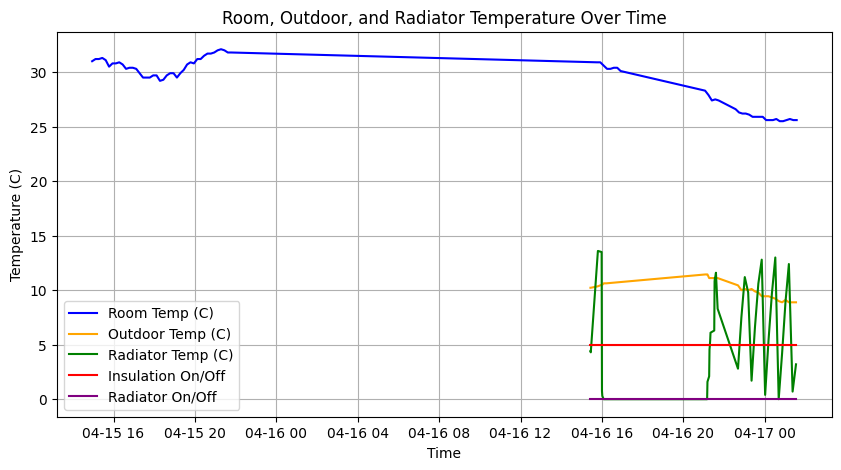

In [12]:

# Plot the time vs room temp, outdoor temp, and radiator temp
plt.figure(figsize=(10, 5))
plt.plot(df6.index, df6[indoorTemp], label='Room Temp (C)', color='blue')
# plt.plot(df1.index, df1['outdoor_temp'], label='Outdoor Temp (C)', color='orange')
plt.plot(df5.index, df5['outdoor_temp'], label='Outdoor Temp (C)', color='orange')
plt.plot(df5.index, df5[radTemp], label='Radiator Temp (C)', color='green')
plt.plot(df5.index, df5['insulation_on']*5, label='Insulation On/Off', color='red')
plt.plot(df5.index, df5['rad_status']*4.5, label='Radiator On/Off', color='purple')

plt.xlabel('Time')
plt.ylabel('Temperature (C)')
plt.title('Room, Outdoor, and Radiator Temperature Over Time')
plt.legend()
plt.grid()
plt.show()

#### Since the sensor is attached to the wall, we may have interference from heat transfer from the adjacent room. Let's collect data from the center of the room and identify the relationship between the temperature at the wall and the temperature at the center of the room.

In [17]:
# Read the CSV files
df_sensor1 = pd.read_csv('all_data_424to427.csv', index_col=0, parse_dates=True)

# Ensure the index is datetime for both DataFrames and set timezone awareness
df_sensor1.index = pd.to_datetime(df_sensor1.index, errors='coerce').tz_localize(None)

# Drop the 'temperature (outdoor)' column from df_sensor
df_sensor1.drop(columns=['temperature (outdoor)'], inplace=True)

# Combine df_sensor and df_outdoor based on timestamp difference
df_sensor1['outdoor_temp'] = np.nan  # Initialize the outdoor_temp column
df_sensor1['duty_cycle'] = 0  # Initialize the duty_cycle column
df_sensor1['dt'] = np.nan

# Iterate through df_sensor and find matching timestamps in df_outdoor
for sensor_idx, sensor_row in df_sensor1.iterrows():
    # Find rows in df_outdoor where the timestamp difference is less than 5 minutes
    matching_outdoor = df_outdoor1.loc[abs(df_outdoor1.index - sensor_idx) < pd.Timedelta(minutes=5)]
    if not matching_outdoor.empty:
        # Take the first matching value (if multiple matches exist)
        df_sensor1.at[sensor_idx, 'outdoor_temp'] = matching_outdoor.iloc[0]['temp C']

df_sensor1.columns = ['sensor_id', 'humidity', 'temperature', 'rad_status', 'insulation_on', 'outdoor_temp', 'duty_cycle', 'dt']
df_radinfo2 = pd.DataFrame(df_sensor1, columns=['rad_status', 'insulation_on', 'outdoor_temp', 'duty_cycle', 'dt'])

df_sensor1 = df_sensor1.pivot_table(
    index='timestamp',            # What you want to be your rows
    columns=['sensor_id'],  # These will become multi-indexed columns
    values = ['temperature', 'humidity']#, 'outdoor_temp', 'rad_status', 'insulation_on']          # Values to fill the table
)

df_sensor1.columns = ['humidity_central', 'humidity_rad', 'humidity_room', 'temp_central', 'temp_rad', 'temp_room']
# df_sensor1.reset_index(inplace=True)

print(df_radinfo2.head(10))
'''
df_sensor1['rad_status'] = 0#df_radinfo2['rad_status']
df_sensor1['insulation_on'] = df_radinfo2['insulation_on']
df_sensor1['outdoor_temp'] = df_radinfo2['outdoor_temp']
df_sensor1['duty_cycle'] = df_radinfo2['duty_cycle']
df_sensor1['dt'] = df_radinfo2['dt']
'''

# Remove duplicate indexes from df_radinfo2
df_radinfo2 = df_radinfo2[~df_radinfo2.index.duplicated(keep='first')]

# Reindex df_radinfo2 to match df_sensor1
df_radinfo2 = df_radinfo2.reindex(df_sensor1.index)

# Assign columns from df_radinfo2 to df_sensor1
df_sensor1['insulation_on'] = df_radinfo2['insulation_on']
df_sensor1['outdoor_temp'] = df_radinfo2['outdoor_temp']
df_sensor1['duty_cycle'] = df_radinfo2['duty_cycle']
df_sensor1['dt'] = df_radinfo2['dt']
df_sensor1['rad_status'] = df_radinfo2['rad_status']

# df_sensor1.columns = ['humidity_rad', 'humidity_room', 'insulation_on_rad', 'insulation_on_room', 'rad_status_rad','rad_status_room', 'temp_rad', 'temp_room']
# df_sensor1.head(20)

# # Drop insulation_on_rad and rad_status_rad columns
# df_sensor1.drop(columns=['insulation_on_rad', 'rad_status_rad'], inplace=True)

# # Rename column "rad_status_room" to "rad_status" and "insulation_on_room" to "insulation_on"
# df_sensor1.rename(columns={'rad_status_room': 'rad_status'}, inplace=True)
# df_sensor1.rename(columns={'insulation_on_room': 'insulation_on'}, inplace=True)

# # Assign all the values for rad_status and insulation_on to 0
# df_sensor1['rad_status'] = 0  
# df_sensor1['insulation_on'] = 0

# # Iterate through df_sensor and find matching timestamps in df_radinfo
# for sensor_idx, sensor_row in df_sensor1.iterrows():
#     # Find rows in df_outdoor where the timestamp difference is less than 5 minutes
#     matching = df_radinfo1.loc[abs(df_radinfo1.index - sensor_idx) < pd.Timedelta(minutes=5)]
#     if not matching.empty:
#         # Take the first matching value (if multiple matches exist)
#         df_sensor1.at[sensor_idx, 'rad_status'] = matching.iloc[0]['rad_status']
#         df_sensor1.at[sensor_idx, 'insulation_on'] = matching.iloc[0]['insulation_on']

# # Add an outdoor_temp column to the df_testing dataframe
# df_sensor1['outdoor_temp'] = np.nan  # Initialize the outdoor_temp column
# df_sensor1['duty_cycle'] = 0  # Initialize the duty_cycle column
# df_sensor1['dt'] = np.nan


# # Iterate through df_testing and find matching timestamps in df_outdoor
# for sensor_idx, sensor_row in df_testing1.iterrows():
#     # Find rows in df_outdoor where the timestamp difference is less than 5 minutes
#     matching_outdoor = df_outdoor1.loc[abs(df_outdoor1.index - sensor_idx) < pd.Timedelta(minutes=5)]
#     if not matching_outdoor.empty:
#         # Take the first matching value (if multiple matches exist)
#         df_sensor1.at[sensor_idx, 'outdoor_temp'] = matching_outdoor.iloc[0]['temp C']

# df_sensor1.drop(df_sensor1.index[0], inplace=True)  # Drop the first two rows to avoid NaN in the first time difference

# Display the updated df_sensor
df_sensor1.head(25)

                     rad_status  insulation_on  outdoor_temp  duty_cycle  dt
timestamp                                                                   
2025-04-24 18:43:00           1              1     30.443889           0 NaN
2025-04-24 18:44:00           1              1     30.443889           0 NaN
2025-04-24 18:53:00           1              1     30.443889           0 NaN
2025-04-24 18:54:00           1              1     30.443889           0 NaN
2025-04-24 20:13:00           1              1     29.444444           0 NaN
2025-04-24 20:14:00           1              1     29.444444           0 NaN
2025-04-24 20:23:00           1              1     29.444444           0 NaN
2025-04-24 20:24:00           1              1     29.444444           0 NaN
2025-04-24 20:33:00           1              1     29.555556           0 NaN
2025-04-24 20:34:00           1              1     29.555556           0 NaN


,humidity_central,humidity_rad,humidity_room,temp_central,temp_rad,temp_room,insulation_on,outdoor_temp,duty_cycle,dt,rad_status
timestamp,,,,,,,,,,,
2025-04-24 18:43:00,NaN,NaN,37.7,NaN,NaN,27.7,1,30.443889,0,NaN,1
2025-04-24 18:44:00,NaN,13.2,NaN,NaN,41.7,NaN,1,30.443889,0,NaN,1
2025-04-24 18:53:00,NaN,NaN,37.7,NaN,NaN,27.7,1,30.443889,0,NaN,1
2025-04-24 18:54:00,NaN,13.2,NaN,NaN,41.7,NaN,1,30.443889,0,NaN,1
2025-04-24 20:13:00,NaN,NaN,37.9,NaN,NaN,27.4,1,29.444444,0,NaN,1
2025-04-24 20:14:00,NaN,11.8,NaN,NaN,43.3,NaN,1,29.444444,0,NaN,1
2025-04-24 20:23:00,NaN,NaN,37.7,NaN,NaN,27.4,1,29.444444,0,NaN,1
2025-04-24 20:24:00,NaN,12.2,NaN,NaN,42.8,NaN,1,29.444444,0,NaN,1
2025-04-24 20:33:00,NaN,NaN,37.8,NaN,NaN,27.3,1,29.555556,0,NaN,1


In [15]:
print(df_sensor1.index.duplicated().sum())  # Count duplicate indexes

print("\n\ndf_sensor1 index:")
print(df_sensor1.index)
print("df_radinfo2 index:")
print(df_radinfo2.index)

0


df_sensor1 index:
DatetimeIndex(['2025-04-24 18:43:00', '2025-04-24 18:44:00',
               '2025-04-24 18:53:00', '2025-04-24 18:54:00',
               '2025-04-24 20:13:00', '2025-04-24 20:14:00',
               '2025-04-24 20:23:00', '2025-04-24 20:24:00',
               '2025-04-24 20:33:00', '2025-04-24 20:34:00',
               ...
               '2025-04-26 11:12:00', '2025-04-26 11:22:00',
               '2025-04-26 11:32:00', '2025-04-27 15:04:00',
               '2025-04-27 15:14:00', '2025-04-27 15:24:00',
               '2025-04-27 15:34:00', '2025-04-27 15:44:00',
               '2025-04-27 15:54:00', '2025-04-27 16:04:00'],
              dtype='datetime64[ns]', name='timestamp', length=398, freq=None)
df_radinfo2 index:
DatetimeIndex(['2025-04-24 18:43:00', '2025-04-24 18:44:00',
               '2025-04-24 18:53:00', '2025-04-24 18:54:00',
               '2025-04-24 20:13:00', '2025-04-24 20:14:00',
               '2025-04-24 20:23:00', '2025-04-24 20:24:00',
      